In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

In [2]:
BATCH_SIZE = 100
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [3]:
class MultiLayerPerceptron(torch.nn.Module):
  def __init__(self,num_features,num_hidden,num_classes):
    super().__init__()
    self.linear1=torch.nn.Linear(num_features,num_hidden)
    self.linear2=torch.nn.Linear(num_hidden,num_classes)

  def forward(self,X):
    out1=self.linear1(X)
    ou1=F.relu(out1)
    logits=self.linear2(out1)
    return logits

  def compute_accuracy_and_loss(self,data_loader,device):
    correct_preds=0
    total_preds=0
    avg_loss=0
    total_batches=0
    for batch_idx,(inputs,targets) in enumerate(data_loader):
      inputs=inputs.reshape(-1,28*28).to(device)
      targets=targets.to(device)
      logits=self.forward(inputs)
      probs=F.softmax(logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      correct_preds+=torch.sum(preds==targets)
      total_preds+=targets.size(0)
      loss=F.cross_entropy(logits,targets)
      avg_loss+=loss
      total_batches+=1

    avg_loss/=total_batches
    accuracy=correct_preds/total_preds
    return accuracy,avg_loss

  def train(self,dataloader,device,num_epochs=30,lr=0.01):
    epoch_cost_arr=[]
    minibatch_cost_arr=[]
    torch.manual_seed(123)
    optimizer=torch.optim.SGD(self.parameters(),lr=lr)

    for epoch in range(num_epochs):
      for batch_idx,(inputs,targets) in enumerate(dataloader):
        inputs=inputs.reshape(-1,28*28).to(device)
        targets=targets.to(device)
        loss=F.cross_entropy(self.forward(inputs),targets)
        minibatch_cost_arr.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      with torch.no_grad():
        train_accuracy,train_loss=self.compute_accuracy_and_loss(dataloader,device)
        epoch_cost_arr.append(train_loss)
        print(f"EPOCH {epoch+1} \t Training Accuracy \t {train_accuracy} \t Training Loss {train_loss} ")

    return epoch_cost_arr,minibatch_cost_arr

In [4]:
mlp=MultiLayerPerceptron(num_features=28*28,num_hidden=200,num_classes=10)

mlp.to(DEVICE)

MultiLayerPerceptron(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [5]:
epoch_cost,minibatch_cost=mlp.train(train_loader,DEVICE)

EPOCH 1 	 Training Accuracy 	 0.8433499932289124 	 Training Loss 0.7115665078163147 
EPOCH 2 	 Training Accuracy 	 0.8741666674613953 	 Training Loss 0.49024084210395813 
EPOCH 3 	 Training Accuracy 	 0.8874499797821045 	 Training Loss 0.41992297768592834 
EPOCH 4 	 Training Accuracy 	 0.8927833437919617 	 Training Loss 0.3852435052394867 
EPOCH 5 	 Training Accuracy 	 0.897516667842865 	 Training Loss 0.3640040457248688 
EPOCH 6 	 Training Accuracy 	 0.9017166495323181 	 Training Loss 0.3496144711971283 
EPOCH 7 	 Training Accuracy 	 0.9040499925613403 	 Training Loss 0.3389880657196045 
EPOCH 8 	 Training Accuracy 	 0.9063000082969666 	 Training Loss 0.3306160271167755 
EPOCH 9 	 Training Accuracy 	 0.9082000255584717 	 Training Loss 0.3239196836948395 
EPOCH 10 	 Training Accuracy 	 0.9098333120346069 	 Training Loss 0.31843528151512146 
EPOCH 11 	 Training Accuracy 	 0.9113166928291321 	 Training Loss 0.31417614221572876 
EPOCH 12 	 Training Accuracy 	 0.9119833111763 	 Training Lo

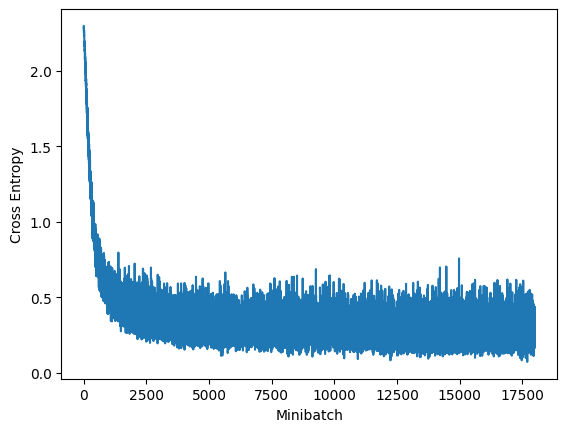

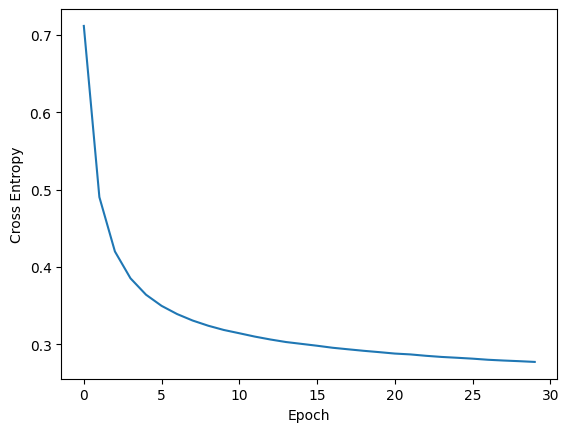

In [6]:
plt.plot(range(len(minibatch_cost)), [cost.detach().numpy() for cost in minibatch_cost])
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), [cost.detach().numpy() for cost in epoch_cost])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [7]:
test_accuracy_loss=mlp.compute_accuracy_and_loss(test_loader,DEVICE)
print(f"Test Accuracy {test_accuracy_loss[0]} \t Test Loss {test_accuracy_loss[1]}")

Test Accuracy 0.9225999712944031 	 Test Loss 0.2764958143234253
